<a href="https://colab.research.google.com/github/RajorshiAdhikaryProjects/Power-Generation-mlr/blob/main/Power_Generation_mlr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import kagglehub


In [2]:
# Attempt to download the dataset
try:
    path = kagglehub.dataset_download("arvindnagaonkar/power-generation-data")
    print("Path to dataset files:", path)
except Exception as e:
    print("Error downloading dataset. Please ensure you have the correct Kaggle API credentials and dataset access.")
    raise RuntimeError(f"Dataset download failed: {e}")


100%|██████████| 18.8M/18.8M [00:02<00:00, 9.21MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arvindnagaonkar/power-generation-data/versions/2


In [3]:
# Load dataset
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dataset_path = os.path.join(path, csv_files[0])
df = pd.read_csv(dataset_path)

In [4]:
display(df.head())
print("Dataset Shape:", df.shape)
print(df.info())
print(df.describe())

,Date,Power Station,Monitored Cap.(MW),Total Cap. Under Maintenace (MW),Planned Maintanence (MW),Forced Maintanence(MW),Other Reasons (MW),Programme (MW),Actual (MW),Excess(+) / Shortfall (-) (MW),Deviation (MW)
0,01-09-2017,Delhi,2235.4,135.0,0.0,135.0,0.0,13.29,18.29,5.00,37.62
1,01-09-2017,STPL,1350.0,1350.0,0.0,1350.0,0.0,0.00,0.00,0.00,0.00
2,01-09-2017,SPPL,150.0,150.0,0.0,150.0,0.0,0.00,0.00,0.00,0.00
3,01-09-2017,SPL,3960.0,0.0,0.0,0.0,0.0,92.13,96.16,4.03,4.37
4,01-09-2017,SKS,600.0,300.0,0.0,300.0,0.0,6.84,7.18,0.34,4.97


Dataset Shape: (334994, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334994 entries, 0 to 334993
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Date                              334994 non-null  object 
 1   Power Station                     334994 non-null  object 
 2   Monitored Cap.(MW)                334994 non-null  float64
 3   Total Cap. Under Maintenace (MW)  334994 non-null  float64
 4   Planned Maintanence (MW)          334994 non-null  float64
 5   Forced Maintanence(MW)            334994 non-null  float64
 6   Other Reasons (MW)                334994 non-null  float64
 7   Programme (MW)                    334994 non-null  float64
 8   Actual (MW)                       334994 non-null  float64
 9   Excess(+) / Shortfall (-) (MW)    334994 non-null  float64
 10  Deviation (MW)                    334994 non-null  float64
dtypes: float64(9), object(2)

In [5]:
# Extract timestamp features if any column contains date information
date_column = None
for col in df.columns:
    if "date" in col.lower():
        date_column = col
        break

if date_column:
    df[date_column] = pd.to_datetime(df[date_column])
    df['Year'] = df[date_column].dt.year
    df['Month'] = df[date_column].dt.month
    df['Day'] = df[date_column].dt.day
    df.drop(columns=[date_column], inplace=True)
else:
    print("Warning: No Date column found in dataset. Skipping timestamp feature extraction.")

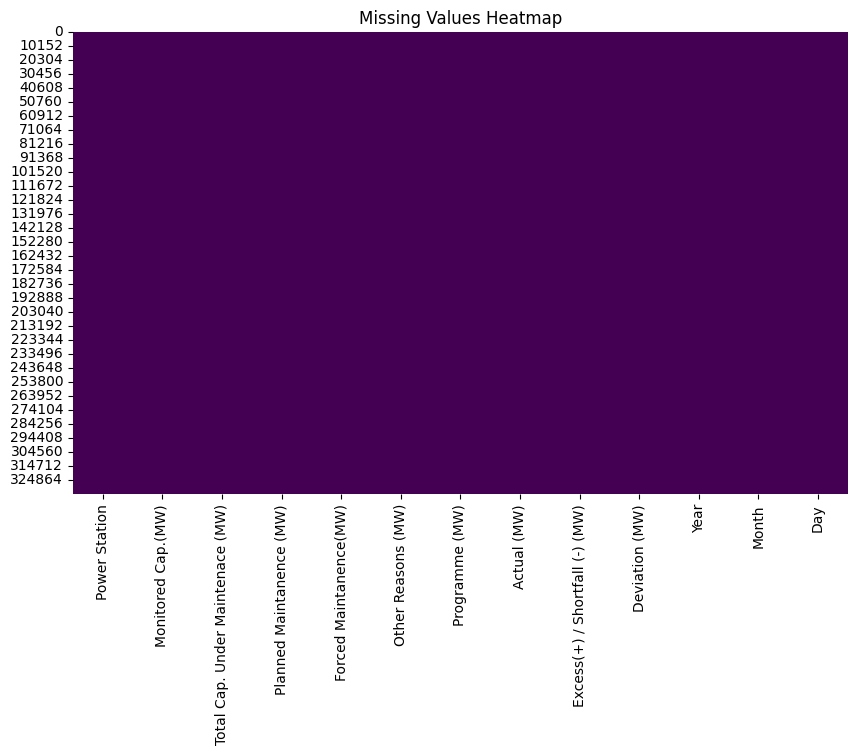

In [6]:
# Visualizing missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


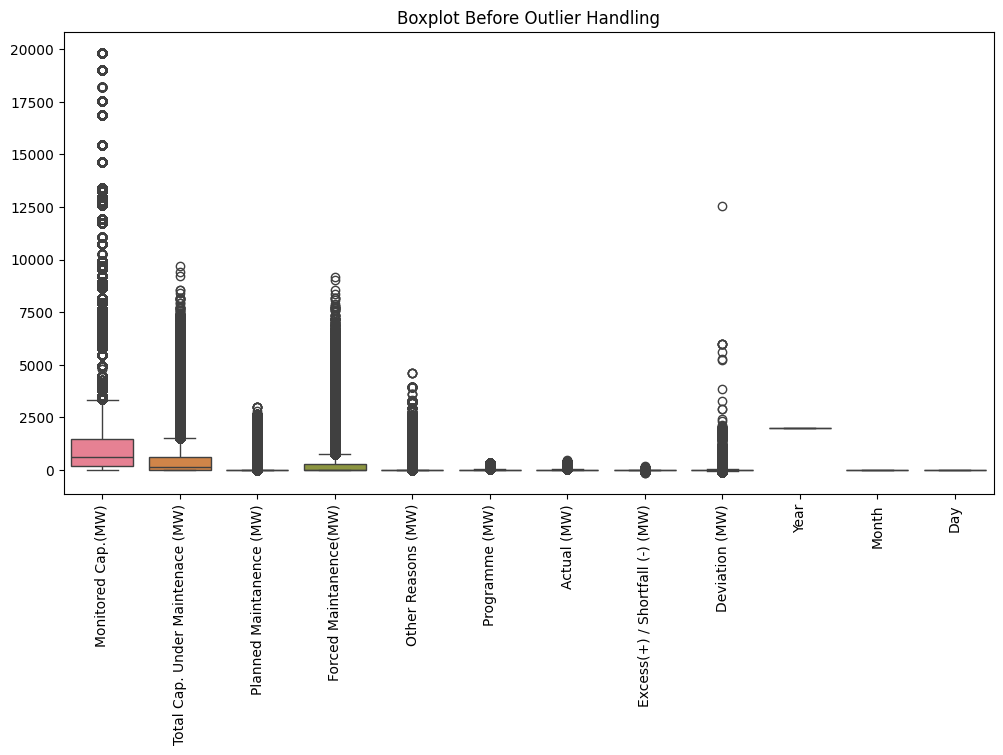

In [7]:
# Boxplot visualization before outlier handling
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot Before Outlier Handling")
plt.show()

In [8]:
# Outlier Detection and Handling using IQR (Only for Numeric Columns)
numeric_cols = df.select_dtypes(include=['number']).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df[numeric_cols] = df[numeric_cols].clip(lower=lower_bound, upper=upper_bound, axis=1)
df[numeric_cols] = df[numeric_cols].applymap(lambda x: max(0, x))  # Ensure no negative values

<ipython-input-8-6321c95a3bfe>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numeric_cols] = df[numeric_cols].applymap(lambda x: max(0, x))  # Ensure no negative values


In [9]:
# Define target variable
df['Total Generation'] = df.iloc[:, 1:].sum(axis=1)
X = df.drop(columns=['Total Generation'])
y_total = df['Total Generation']


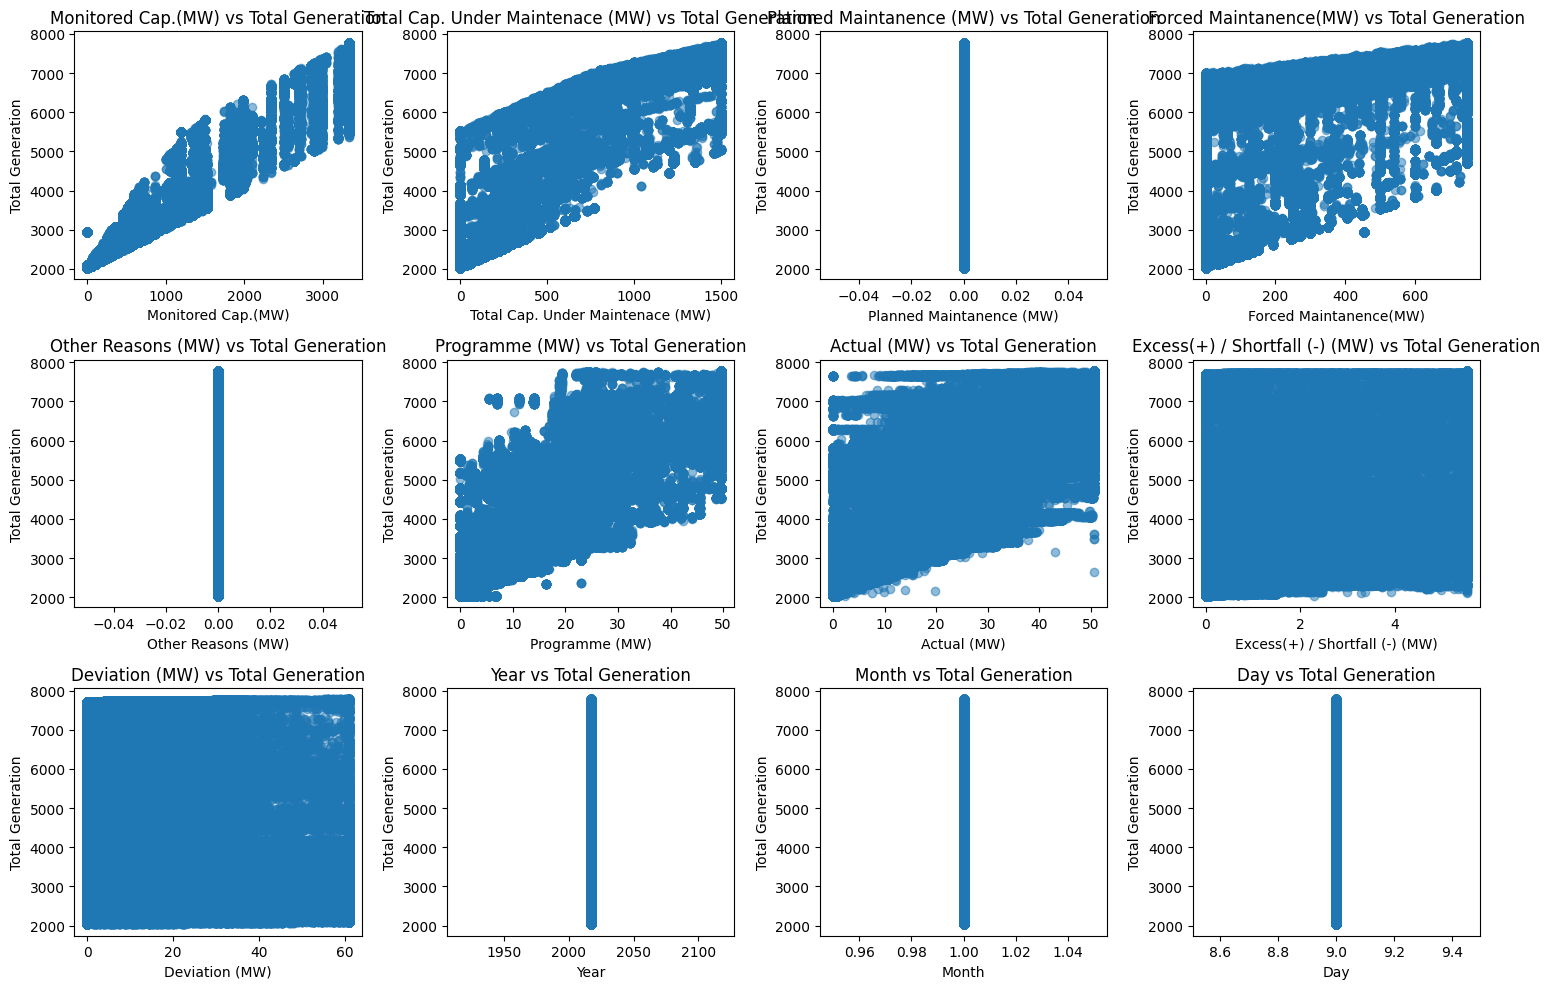

In [10]:
# Scatter Plots for Feature Analysis
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.select_dtypes(include=['number']).columns, 1):
    plt.subplot(3, 4, i)
    plt.scatter(X[col], y_total, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Total Generation')
    plt.title(f'{col} vs Total Generation')
plt.tight_layout()
plt.show()

In [11]:
# Encode Categorical Variables
X = pd.get_dummies(X, drop_first=True)  # Convert categorical columns to numeric

In [12]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Feature Selection
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_scaled, y_total)
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_features)

In [14]:
# Define model
model = LinearRegression()

In [15]:
# Cross-validation and Model Evaluation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_score = np.mean(scores)
    model.fit(X, y)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    plt.figure(figsize=(10,6))
    plt.scatter(y, y_pred, color='red', alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title("Actual vs Predicted")
    plt.show()

    # Feature Importance Plot
    feature_importance = np.abs(model.coef_)
    plt.figure(figsize=(10,6))
    sns.barplot(x=selected_features, y=feature_importance)
    plt.xticks(rotation=90)
    plt.title("Feature Importance")
    plt.show()

    # Residual Plot
    residuals = y - y_pred
    plt.figure(figsize=(10,6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    plt.show()

    print(f"Linear Regression Performance:\n")
    print(f"Cross-validation R2 Scores: {scores}")
    print(f"Mean R2 Score: {mean_score}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}\n")
    return mean_score

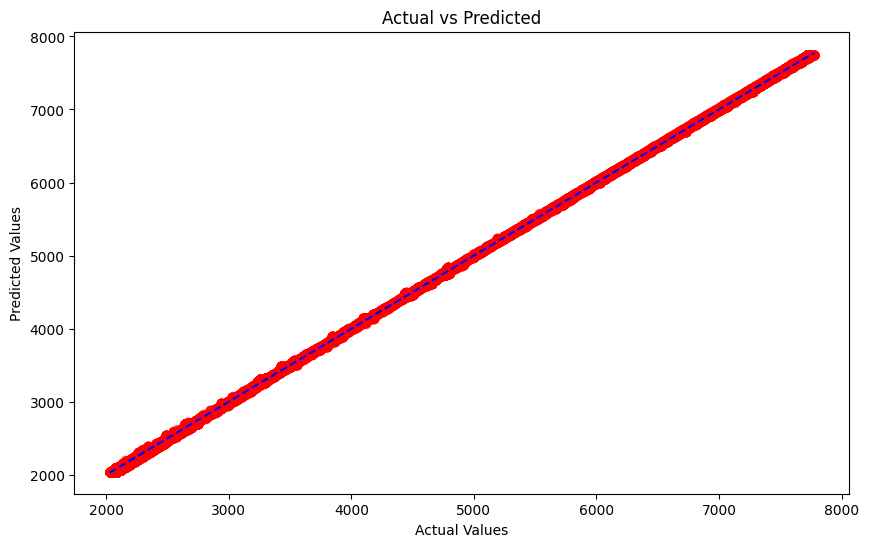

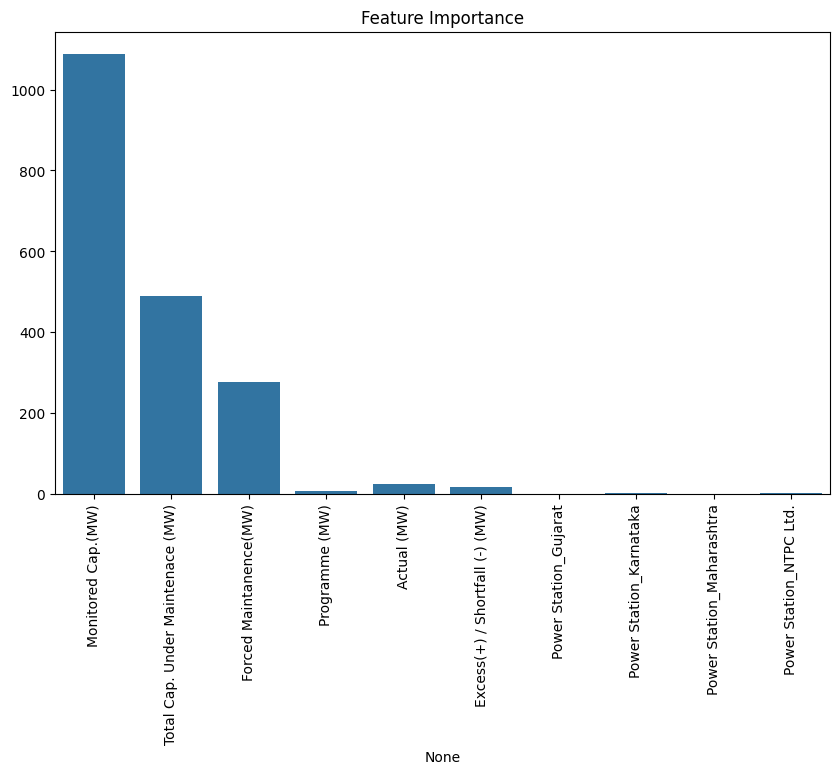

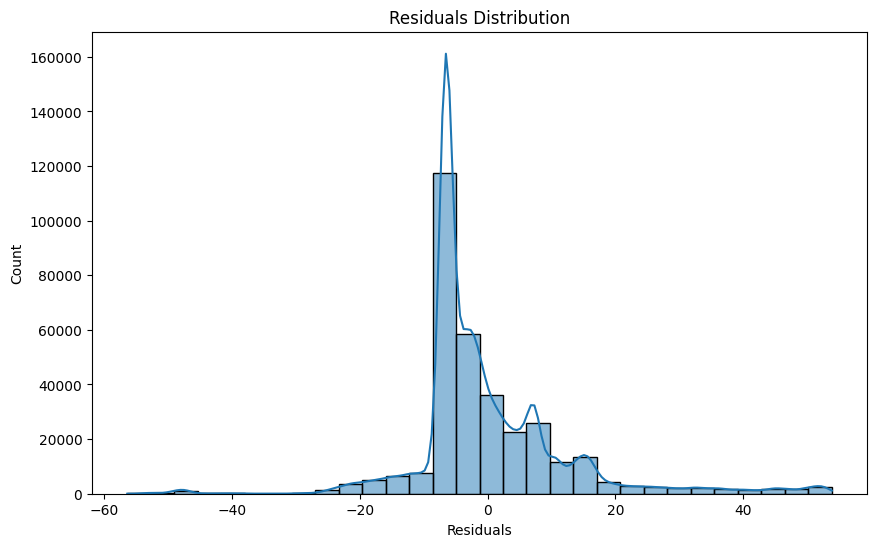

Linear Regression Performance:

Cross-validation R2 Scores: [0.99995187 0.99995179 0.99994643 0.99994994 0.99994106]
Mean R2 Score: 0.9999482156145969
MAE: 8.42678156660477, MSE: 152.54821310815313, RMSE: 12.351040972653, R2 Score: 0.9999484782931312



np.float64(0.9999482156145969)

In [16]:
# Evaluate model
evaluate_model(model, X, y_total)

In [17]:
# Save the Model
with open("best_power_generation_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully!")


Model saved successfully!
